# Training Baseline

Tasks in this notebook(Luda):
- sanity check inputs
- Use sklearn to do multilabel classification. We will train a OVA (one vs all) models for each distinct labels and then assign labels by the classifier output of each of the models. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from collections import *
import seaborn as sns
%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


# Count Tags

In [3]:
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 116484 non-unique tags in all training images
average number of labels per image 2.87764025791


In [4]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

,tag,0
12,primary,37840
5,clear,28203
0,agriculture,12338
13,road,8076
16,water,7262


# Check out the Images again

In [3]:
from glob import glob
image_paths = sorted(glob('../data/train-jpg/*.jpg'))[0:10]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

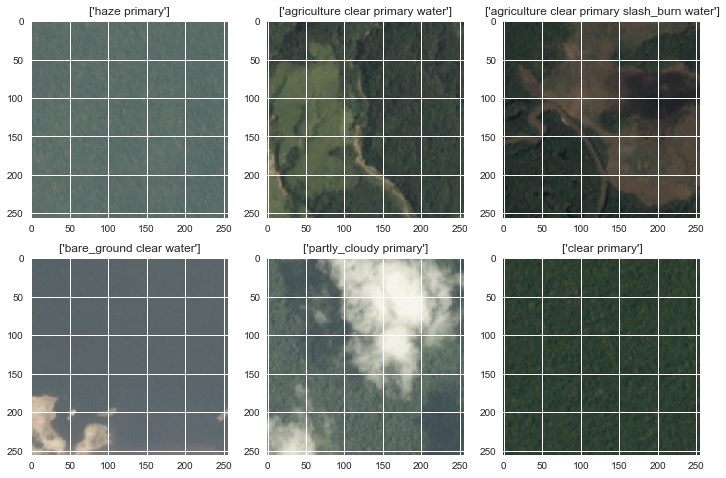

In [4]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(df[df.image_name == image_names[i]].tags.values))

# Training

Note: this is adapted from Philipp Schmidt's "Multilabel Classification & Rainforest EDA" Kernel on Kaggle.


In [25]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings

In [11]:
df.head(10)['image_name'].values

array(['train_0', 'train_1', 'train_2', 'train_3', 'train_4', 'train_5',
       'train_6', 'train_7', 'train_8', 'train_9'], dtype=object)

In [14]:
# Process data into training set and labels

%time
n_samples = 500 #small sampling dataset
rescaled_dim = 20

df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]

#sample
print "classes:"
print lb.classes_
print "y shape:", y.shape
print "y labels look like this:"
print y[:5]


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 20 µs
classes:
['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']
y shape: (500, 17)
y labels look like this:
[[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]]


In [15]:
imgs = []
# for each image, rescale to same dimension and flattern
for name in df.head(n_samples)['image_name'].values:
    raw_img = plt.imread('../data/train-jpg/{}.jpg'.format(name))
    #print raw_img
    imgs.append(cv2.resize(raw_img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1))

# remove dimenions    
X = np.squeeze(np.array(imgs))

# scale X so that each feature be between 0 and 1
X = MinMaxScaler().fit_transform(np.float32(X))

print "X shape:",(X.shape)
print np.min(X, axis=0), np.max(X, axis=0)

X shape: (500, 1600)
[ 0.  0.  0. ...,  0.  0.  0.] [ 0.99999994  1.          1.         ...,  1.          1.          0.        ]


In [16]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((335, 1600), (165, 1600), (335, 17), (165, 17))


In [17]:
# Train Classifier
%time
clf = OneVsRestClassifier(LogisticRegression(C=10, penalty='l2'))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clf.fit(X_train, y_train)

print

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs



In [18]:
# evaluate output

score = fbeta_score(y_test, clf.predict(X_test), beta=2, average=None)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')
print('Average F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Average F2 test score 0.582724217735
F2 test scores per tag:


/Users/luda/Library/Python/2.7/lib/python/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luda/Library/Python/2.7/lib/python/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[('primary', 0.92790387182910561),
 ('clear', 0.82191780821917815),
 ('cloudy', 0.39772727272727276),
 ('bare_ground', 0.3125),
 ('habitation', 0.22388059701492541),
 ('partly_cloudy', 0.22151898734177217),
 ('agriculture', 0.2109704641350211),
 ('road', 0.19774011299435026),
 ('cultivation', 0.12658227848101264),
 ('haze', 0.10204081632653063),
 ('water', 0.059523809523809527),
 ('conventional_mine', 0.0),
 ('slash_burn', 0.0),
 ('blow_down', 0.0),
 ('blooming', 0.0),
 ('selective_logging', 0.0),
 ('artisinal_mine', 0.0)]

In [50]:
# consolidate above into functions. We can re-use these modular functions later.

# Preprocess images
# Input: number of samples, dim, path
# Output: X, y, list of class names
def preprocess(n_samples, rescaled_dim, f_path ="../data/train.csv"):
    df = pd.read_csv(f_path)
    df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
    lb = MultiLabelBinarizer()
    y = lb.fit_transform(df['split_tags'])
    y = y[:n_samples]
    
    imgs = []
    # for each image, rescale to same dimension and flattern
    for name in df.head(n_samples)['image_name'].values:
        raw_img = plt.imread('../data/train-jpg/{}.jpg'.format(name))
        #print raw_img
        imgs.append(cv2.resize(raw_img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1))

    # remove dimenions    
    X = np.squeeze(np.array(imgs))

    # scale X so that each feature be between 0 and 1
    X = MinMaxScaler().fit_transform(np.float32(X))
    
    return X, y, lb.classes_

# Train a model
# Input: X_train, y_train, a model with the function "fit"
def train_model(X_train, y_train, model):

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train, y_train)
    
    return model

# Using a trained model, calculate the F2_score
# input: X_test, y_test, model
# output: a list of F2_score by class(length 17)
def calc_F2_score(X_test, y_test, model):
    score = fbeta_score(y_test, model.predict(X_test), beta=2, average=None)
    #avg_sample_score = fbeta_score(y_test, model.predict(X_test), beta=2, average='samples')
    #print('Average F2 test score {}'.format(avg_sample_score))
    #print('F2 test scores per tag:')
    #[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]
    return score
    
    
# define cross validation
def cross_validation_train_score(X, y, model, scoring_func, folds=10):
    print "Using cross validation with folds", folds
    print "X shape:", X.shape
    print "y shape:", y.shape
    kf = KFold(n_splits=folds, shuffle=True)
    scores_all = []
    for ind, (train, test) in enumerate(kf.split(X)):
        print "Fold ", ind
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

        model = train_model(X_train, y_train, model)
        score = scoring_func(X_test, y_test, model)
        scores_all.append(score)
        
    return np.mean(np.array(scores_all), axis=0)

# Complete Pipeline from raw image to scores

- Combining all of the functions above, write complete pipeline for classification

In [52]:
%%time

NUM_TRAIN = 40482
NUM_SAMPLE = NUM_TRAIN
DIM = 64

X, y, ind_to_classes = preprocess(NUM_SAMPLE, DIM, "../data/train.csv")
model = OneVsRestClassifier(LogisticRegression(C=10, penalty='l2'))
cv_f2_scores = cross_validation_train_score(X, y, model, calc_F2_score, 5)

# print the scores with the classes
print [(ind_to_classes[l], cv_f2_scores[l]) for l in cv_f2_scores.argsort()[::-1]]

Using cross validation with folds 5
X shape: (100, 16384)
y shape: (100, 17)
Fold  0
Fold  1
Fold  2
Fold  3
Fold  4
[('primary', 0.88795508353435193), ('clear', 0.87446657509157499), ('cloudy', 0.35833333333333334), ('agriculture', 0.16735042735042732), ('road', 0.15656565656565657), ('habitation', 0.11111111111111112), ('partly_cloudy', 0.090909090909090912), ('water', 0.039999999999999994), ('slash_burn', 0.0), ('conventional_mine', 0.0), ('haze', 0.0), ('selective_logging', 0.0), ('blow_down', 0.0), ('blooming', 0.0), ('bare_ground', 0.0), ('artisinal_mine', 0.0), ('cultivation', 0.0)]
CPU times: user 22.5 s, sys: 1.3 s, total: 23.8 s
Wall time: 24.8 s
